# Bose-Einstein Condensates and the Involvement in Advances for New Technologies

In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

First, we  need to discrete our spatial and temporal domains, i.e., we have to consider $\psi(x_i, t_j)$  with equally-spaced points in space and time, $x_i = i \Delta x$ and $t_j = j \Delta t$ (integer $i$ and $j$). Aditionally, we will import the necessary libraries and defining the spatial domain $L$ of the problem.

In [2]:
# Defining the spatial domain  with size [-L, L]
L = 10

# Defining the number of steps in space and time
Nx = 100
Nt = 1000

# Defining the spacial steps
dx = 2 * L / Nx  
x = np.linspace(-L, L, Nx)  # Discretized spatial domain

 # Time step
dt = 0.01

We can also define a function to compute second spatial derivative (finite difference), wich we will need to update the wavefunction:

\begin{equation}
    \frac{\partial^2 f(x_i, t_i)}{\partial x^2} \approx \left [\frac{f(x_{i+1}, t_j) - 2f(x_i, t_j) + f(x_{i-1}, t_j)}{\Delta x^2}  \right ]  
\end{equation}

This can be done by using the numpy function `np.roll()`. Given a function $f(x, t) = (x_0, t) + (x_1, t) + ... + (x_i, t) + ...$, we have
- `np.roll(f, -1)`$ = (x_1, t) + (x_2, t) + ... + (x_{i+1}, t) + ...$.
- `np.roll(f, 1)`$ = (x_0, t) + (x_0, t) + (x_1, t) + ... + (x_{i-1}, t) + ...$.

In [3]:
def laplacian(f, dx):
    return (np.roll(f, -1) - 2 * f + np.roll(f, 1)) / dx**2

Now we can define the wavefunction update. 

##### i) For the linear case, 

We need to compute the half-step for I, wich is defined as

\begin{equation}
I_{lin} (x, \Delta t /2 ) = I(x, 0) - H R(x,0) \frac{\Delta t}{2}
\end{equation}

Then, we can compute the full steps for R and I

\begin{equation}
    R_{lin}(x, t + \Delta t/2) = R(x, t - \Delta t / 2) + \Delta t \ H \ I (x, t)
\end{equation}

\begin{equation}
    I_{lin}(x, t + \Delta t/2) = I(x, t - \Delta t / 2) + \Delta t \ H \ R (x, t)
\end{equation}


##### ii) For the non-linear case, 

We can redefine theses functions as:

\begin{equation}
    R_{nonlin}(t + \Delta t/2) = R_{lin} + \frac{\Delta t U_0 I^2(x, t)}{1 - \Delta t R (t- \Delta t/2)I(t)}
\end{equation}

\begin{equation}
    I_{lin}(x, t + \Delta t/2) = I_{lin} - \frac{\Delta t U_0 R^2(x, t)}{1 + \Delta t I (t- \Delta t/2)R(t)}
\end{equation}

and the half-step of I:

\begin{equation}
    I_{lin}(x, t + \Delta t/2) = I_{lin} - \frac{\Delta t}{2} U_0 (R^2(x, 0) + I^2(x, 0))R(x, 0)
\end{equation}

We chose to concentrate these equations on the same function, so that the user can choose to add the nonlinear contribution to the equation by passing the `True` parameter to the `nonlinear` variable. The half-step is define in the main function. 

In [4]:
def update_wavefunction(R, I, dt, dx, V, U0, nonlinear):

    # Update R at full step
    R_full = R + dt * (-0.5 * laplacian(I, dx) + V * I)

    # Update R at full step in nonlinear case
    if nonlinear:
        R_full += dt * U0 * (I**2) * I
        R_full = R_full/(1 - dt*U0*R*I)

    # Update I at full step
    I_full = I - dt * (-0.5 * laplacian(R_full, dx) + V * R_full)

    # Update I at full step in nonlinear case
    if nonlinear:
        I_full -= dt * U0 * (R_full**2) * R_full
        I_full = I_full/(1 + dt*U0*I*R_full)
    
    return R_full, I_full

We choose to compute the probability density using 

\begin{equation}
    P(x, t) = R^2(x, t) + I(x, t + \Delta t /2)I(x, t - \Delta t /2)
\end{equation}

wich `I` is the $I(x, t + \Delta t /2)$ in the above equation and `I_minus` is $I(x, t + \Delta t /2)$. 

In [5]:
def probability_density(R, I, I_minus, dt, t_step):
    return R**2 + I * I_minus

We can get the time evolution of our system given $R(x, 0)$ and $I(x, \Delta t / 2)$. We choose to plot a graph of the probability density every 200 steps, so...  

In [6]:
# Time evolution with stability check

def time_evolution(R, I, Nt, dt, dx, V, U0, nonlinear):
    R_t, I_t = R.copy(), I.copy()
    
    for t in range(Nt):
        I_minus = I_t
        R_t, I_t = update_wavefunction(R_t, I_t, dt, dx, V, U0, nonlinear)
        P = probability_density(R_t, I_t, I_minus, dt, t)
        if t % 200 == 0:  # Plot every 100 time steps
            plt.plot(x, P, label=f't={t*dt:.3f}')
    plt.xlabel('x')
    plt.ylabel('P(x, t)')
    plt.title('Time Evolution of Probability Density')
    plt.legend()
    plt.show()
        

Also we can cheek the stability condition

\begin{equation}
    \frac{-2}{\Delta t} < V < \frac{2}{\Delta t} - \frac{2}{(\Delta x)^2}
\end{equation}

In our case $V \geq 0$, so $\frac{-2}{\Delta t} < V$ is always true. We need to worry only about the inequality $V < \frac{2}{\Delta t} - \frac{2}{(\Delta x)^2}$. So  we need to worry about $Max\{V\} < \frac{2}{\Delta t} - \frac{2}{(\Delta x)^2}$

In [7]:
# Function to verify the stability condition
def check_stability(dt, dx, V):
    # Calculate stability criterion
    if (np.max(V) < (2/dt - 2/(dx**2))):
        return True
    else: 
        print(f"Warning: Time step {dt} exceeds stability limit")
        return False

Finally, we can define our main function to compute the algorithm.  The function consists in compute the half-step of I considering the nonlinear case and, if `nonlinear = True`, it adds the nonlinear term to I_half. Then it computes the time evolution defined before, sending the parameter of `nonlinear` to show corresponding results. 

In [8]:
# Main function to run the simulation
def main(nonlinear):
    I_half = I - dt / 2 * (-0.5 * laplacian(R, dx) + V * R)

    # Check stability condition
    if not check_stability(dt, dx, V):
        return

    if nonlinear == False:
        # Non-interacting case (TISE)
        print("Simulating non-interacting case")
        time_evolution(R, I_half, Nt, dt, dx, V, U0=0, nonlinear=False)

    else:
        # Interacting case (GPE)
        I_half -= dt / 2 * U0 * (R**2 + I**2) * R
        print("Simulating interacting case (GPE)")
        time_evolution(R, I_half, Nt, dt, dx, V, U0, nonlinear=True)

### a) Consider the initial state 

\begin{equation}
    \psi(x, 0) = (1/x)^{1/4} e^{-x^2/2}
\end{equation}

What happens? Why? 

We need to define the $R(x, 0)$ and $I(x, 0)$ considering the initial states. Furthermore, we can especify the potential in the cell bellow. Since we are dealing with the linear equation, we must pass the parameters `nonlinear = False`. Bellow the cell, we can se the graph in diferente time, so we can study the dynamics of the system.

Simulating non-interacting case


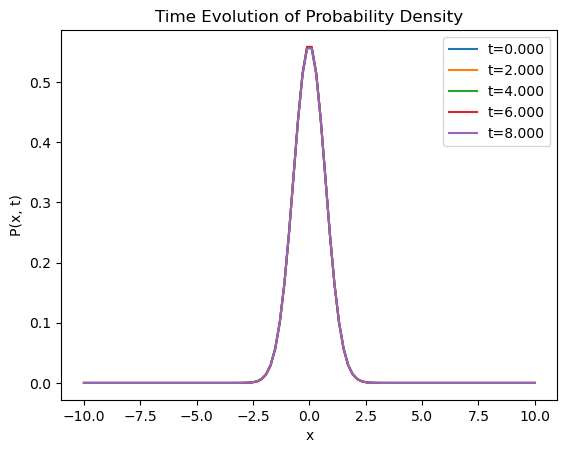

In [9]:
# Harmonic potential V(x) = (1/2)x^2
V = 0.5 * x**2  

# Initial condition for ψ(x, 0) = ((1/\pi)^(1/4)) * \exp(-x²/2)
R = ((1/np.pi)**(1/4)) * np.exp((-x**2)/2)  # Real part
I = np.zeros(Nx)  # Imaginary part



if __name__ == "__main__":
    main(nonlinear = False)

As a result, we have a density probability that don´t change in time. It happens beacause the initial state corresponds to the ground state of the quantum harmonic oscillator, wich is an eigenvalue of the Hamiltonian with the potential $V(x) = \frac{1}{2}x^2$. As a result, the probability distribution does not change over time, only acquiring a global phase. This is, therefore, an stationary state. 

### b)  Consider the initial state 

\begin{equation}
    \psi(x, 0) = (2/x)^{1/4} e^{-x^2}
\end{equation}

What happens? Why? 

We need to define the $R(x, 0)$ and $I(x, 0)$ considering the initial states. Furthermore, we can especify the potential in the cell bellow. Since we are dealing with the linear equation, we must pass the parameters `nonlinear = False`. Bellow the cell, we can se the graph in diferente time, so we can study the dynamics of the system.

Simulating non-interacting case


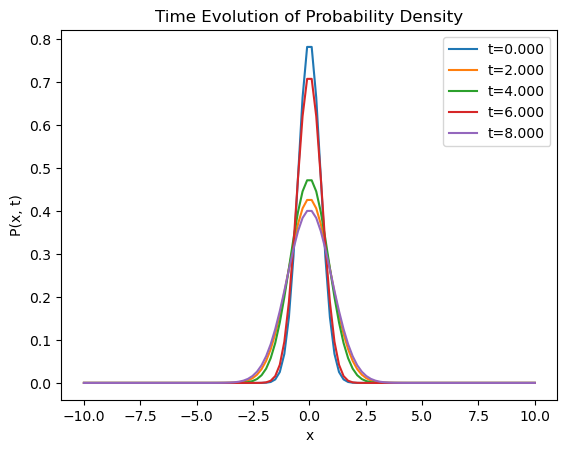

In [10]:
# Harmonic potential V(x) = (1/2)x^2
V = 0.5 * x**2  

# Initial condition for ψ(x, 0) = ((1/\pi)^(1/4)) * \exp(-x²/2)
R = ((2/np.pi)**(1/4)) * np.exp(-x**2)  # Real part
I = np.zeros(Nx)  # Imaginary part

if __name__ == "__main__":
    main(nonlinear = False)

As a result, we have a density probability that changes in time. It happens beacause we are not dealing with a state that is a eigenvector of the Hamiltonian, as before. Because the initial state is not the ground state, it evolves as a superposition of harmonic oscillator eigenstates. These eigenstates oscillate with different frequencies, which causes interference effects over time. This interference can cause the probability distribution to spread and decrease in amplitude.This is, therefore, a nonstationary state. 

### c) Consider the initial state Now that we have some familiarity with the non-interacting case, we can consider the one-dimensional GPE. We have to modify our algorithm to take into account the non- linear term. This can be done by using Eqs. (14) and (15) for including the non-linear term $U_0 \vert \psi(x, t) \vert$ into Eqs. (11) and (12),

\begin{equation}
    \psi(x, 0) = \frac{1}{\sqrt{2} cosh(x)}
\end{equation}

What happens? Why? 

We need to define the $R(x, 0)$ and $I(x, 0)$ considering the initial states. Furthermore, we can especify the potential in the cell bellow ($V= 0$ in this case). Since we are dealing with the GPE (nonlinear), we must pass the parameters `nonlinear = True`. Bellow the cell, we can se the graph in diferente time, so we can study the dynamics of the system.

Simulating interacting case (GPE)


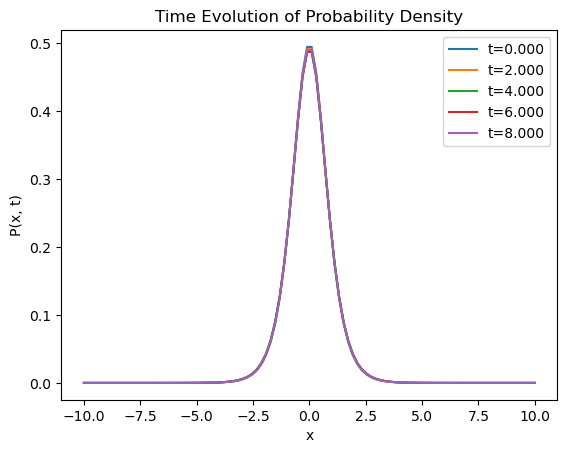

In [11]:
# Nonlinear interaction term for GPE
U0 = -2  
V = 0*x

# Initial condition for ψ(x, 0)
R = 1/(np.sqrt(2)*np.cosh(x)) # Real part

I = np.zeros(Nx)  # Imaginary part

if __name__ == "__main__":
    # Hamiltonian without potential
    main(nonlinear = True)

As a result, the density probability does not change significantly. It happens beacause the initial state is a soliton. In the context of the GPE, which can describes Bose-Einstein systems with interactions, solitons are stable solutions that can maintain their shape over time. Solitons arise due to the non-linear interaction between particles, which counterbalances the natural dispersion that occurs in a quantum system.  This explains why the probability density does not evolve, even with the presence of a non-linear term in the equation.

For attractive interactions ($U_0 < 0$, as in our case), this type of solution corresponds to a dark or bright soliton, depending on the boundary conditions and amplitude. With $U_0 = -2$ and potential $V(x) = 0$, the solitonic solution maintains its shape over time, differently from what happens with other states.

In the Bose-Einstein formalism, this represents a coherent solution in a regime of specific interactions that prevents condensate dispersion. It is a well-known behavior in cold atom systems described by the GPE.